In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import SVG, HTML
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD
from keras.utils.vis_utils import model_to_dot
from mpl_toolkits.mplot3d import Axes3D
from operator import itemgetter
from scipy.interpolate import spline
from scipy.stats import poisson
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR, SVC
from xgboost import XGBClassifier, XGBRegressor

from helper_fcts import preprocess, get_poi_mas, rps
from modelling import modelling

C:\Users\Konny\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.concat([modelling(pd.read_csv("data/E" + str(i) + ".csv"), 20) for i in range(8,19)])

C:\Users\Konny\Anaconda3\lib\site-packages\scipy\stats\_discrete_distns.py:493: RuntimeWarning: invalid value encountered in greater_equal
  return mu >= 0


![](pics/bookie_big.jpg)

![](pics/animal_predictions.png)

# Data Science Work-Flow // Table of Contents
1. problem definition
2. data exploration
3. feature engineering
4. modelling
5. evaluation

## 1. Definition of the problem
- predict football matches
- but how to rate predictions?

#### 1.1 Accuracy
- not a good measure
- for example: 50% accuracy when betting on favorites is worse than 50% accuracy when betting on underdogs

#### 1.2 Classification
- Difficult to measure/compare

In [4]:
df["Res"] = np.where(df["FTHG"] > df["FTAG"], "green", np.where(df["FTHG"] == df["FTAG"], "yellow", "red"))
df_vis = df[df["season"] == 18].loc[:,["Res", "H_prob_odds", "D_prob_odds", "A_prob_odds"]]

In [5]:
%matplotlib notebook

<IPython.core.display.Javascript object>


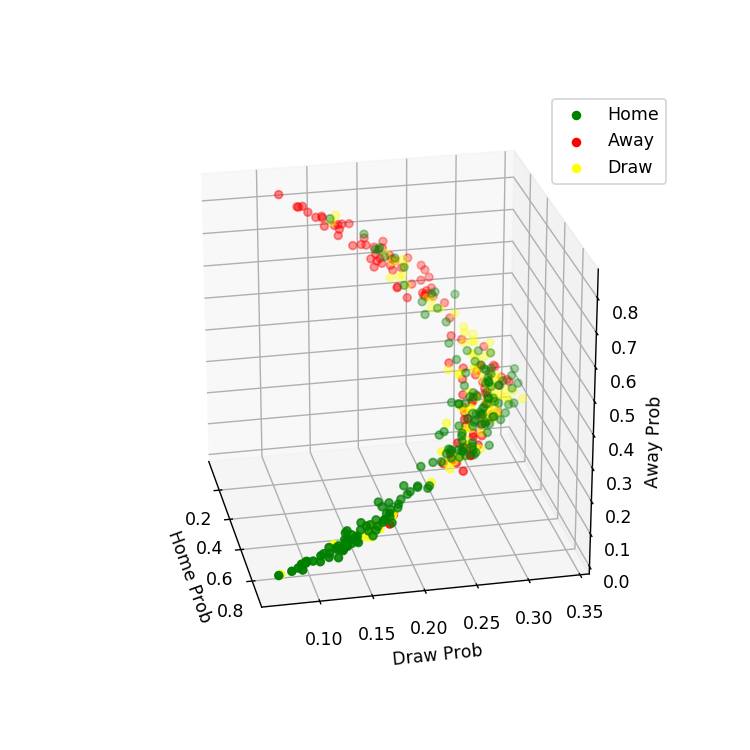

In [6]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

for res, group in df_vis.groupby("Res"):
    ax.scatter(group["H_prob_odds"], group["D_prob_odds"], group["A_prob_odds"], c=res)

ax.legend(["Home", "Away", "Draw"])

ax.set_xlabel('Home Prob')
ax.set_ylabel('Draw Prob')
ax.set_zlabel('Away Prob')

plt.show()

### 1.3 Rank Probability Score (RPS)
- score to rank predictions
- the lower the better
- good measure

In [7]:
print("---------------------------------------")
print(f"\nBookmaker RPS (Season 18): {np.round(df[(df['season'] == 18) & (df['round'] > 10)]['rps_Book'].mean(),4)}\n")
print("---------------------------------------")

---------------------------------------

Bookmaker RPS (Season 18): 0.1826

---------------------------------------


## 2. Data Exploration
- Premier League
- Seasons 07/08 to 17/18

### 2.1 Sources:
- football-data.co.uk
- sportdeer.com (API)

In [8]:
print("------------------------------")
print(f"Number of Seasons in the dataset: {df.season.nunique()}")
print(f"Number of Matches in the dataset: {df.shape[0]}")
print(f"Number of Features per Match: {df.shape[1]}")
print("------------------------------")

------------------------------
Number of Seasons in the dataset: 11
Number of Matches in the dataset: 4180
Number of Features per Match: 183
------------------------------


In [9]:
df[["Date", "season", "round", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR", "HS", "HST", "AS", "AST", "BbAvH", "BbAvD", "BbAvA"]].head(20)

,Date,season,round,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,HST,AS,AST,BbAvH,BbAvD,BbAvA
0,11/08/07,8,1,Aston Villa,Liverpool,1,2,A,10,6,17,7,3.67,3.23,1.95
1,11/08/07,8,1,Bolton,Newcastle,1,3,A,13,9,7,5,2.41,3.18,2.80
2,11/08/07,8,1,Derby,Portsmouth,2,2,D,12,5,12,6,2.85,3.19,2.38
3,11/08/07,8,1,Everton,Wigan,2,1,H,12,8,14,4,1.66,3.45,5.25
4,11/08/07,8,1,Middlesbrough,Blackburn,1,2,A,10,6,4,4,2.41,3.18,2.81
5,11/08/07,8,1,Sunderland,Tottenham,1,0,H,9,4,6,3,3.18,3.21,2.18
6,11/08/07,8,1,West Ham,Man City,0,2,A,9,2,14,5,2.05,3.20,3.52
7,12/08/07,8,1,Arsenal,Fulham,2,1,H,19,13,12,9,1.32,4.49,9.40
8,12/08/07,8,1,Chelsea,Birmingham,3,2,H,19,11,6,4,1.19,5.74,13.52
9,12/08/07,8,1,Man United,Reading,0,0,D,22,9,3,2,1.23,5.26,12.24


### 2.2 Home/Draw/Away Distribution

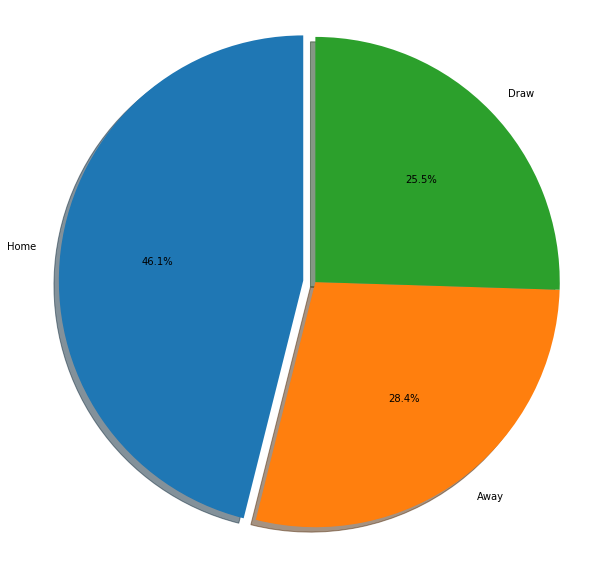

In [10]:
%matplotlib inline

home_wins = np.round(df[df["FTR"]=="H"].shape[0] * 100 / df.shape[0], 2)
draw_wins = np.round(df[df["FTR"]=="D"].shape[0] * 100 / df.shape[0], 2) 
away_wins = np.round(df[df["FTR"]=="A"].shape[0] * 100 / df.shape[0], 2) 

labels = 'Home', 'Away', 'Draw'
sizes = [home_wins, away_wins, draw_wins]
explode = (0.05, 0, 0)

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

## 3. Feature Engineering

In [11]:
df[["Date", "season", "round", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR", "HS", "HST", "AS", "AST", "BbAvH", "BbAvD", "BbAvA"]].head(5)

,Date,season,round,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,HST,AS,AST,BbAvH,BbAvD,BbAvA
0,11/08/07,8,1,Aston Villa,Liverpool,1,2,A,10,6,17,7,3.67,3.23,1.95
1,11/08/07,8,1,Bolton,Newcastle,1,3,A,13,9,7,5,2.41,3.18,2.80
2,11/08/07,8,1,Derby,Portsmouth,2,2,D,12,5,12,6,2.85,3.19,2.38
3,11/08/07,8,1,Everton,Wigan,2,1,H,12,8,14,4,1.66,3.45,5.25
4,11/08/07,8,1,Middlesbrough,Blackburn,1,2,A,10,6,4,4,2.41,3.18,2.81


### 3.1 Averages
- match statistics cannot be used, because we dont know them before the match
- use averages from the past games instead

In [12]:
df[["HomeTeam", "AwayTeam", "H_avgG", "A_avgG", "H_avgG_c", "A_avgG_c", "H_avgST", "A_avgST", "H_avgST_c", "A_avgST_c", "Lg_HG", "Lg_AG"]].tail(5)

,HomeTeam,AwayTeam,H_avgG,A_avgG,H_avgG_c,A_avgG_c,H_avgST,A_avgST,H_avgST_c,A_avgST_c,Lg_HG,Lg_AG
375,Newcastle,Chelsea,1.111111,1.629630,0.796296,1.259259,3.574074,4.462963,3.166667,3.888889,1.520000,1.141333
376,Southampton,Man City,1.074074,2.518519,1.370370,0.703704,4.407407,5.944444,3.944444,2.407407,1.523936,1.138298
377,Swansea,Stoke,1.092593,0.648148,1.092593,1.759259,3.759259,3.314815,4.166667,6.481481,1.519894,1.137931
378,Tottenham,Leicester,1.796296,1.500000,0.611111,2.055556,6.000000,3.481481,3.129630,5.222222,1.518519,1.140212
379,West Ham,Everton,1.166667,0.944444,1.370370,1.777778,3.444444,3.425926,4.074074,5.462963,1.527704,1.147757


### 3.2 Ratings

In [13]:
df1 = df[df["season"] == 18][["round", "HomeTeam", "AwayTeam", "H_Off_Rat", "H_Def_Rat", "A_Off_Rat", "A_Def_Rat"]]

home_off = df1.pivot(columns="HomeTeam", values="H_Off_Rat")
home_def = df1.pivot(columns="HomeTeam", values="H_Def_Rat")
away_off = df1.pivot(columns="AwayTeam", values="A_Off_Rat")
away_def = df1.pivot(columns="AwayTeam", values="A_Def_Rat")

home_off.fillna(method="pad", inplace=True)
home_off = home_off.iloc[100:]

home_def.fillna(method="pad", inplace=True)
home_def = home_def.iloc[100:]

away_off.fillna(method="pad", inplace=True)
away_off = away_off.iloc[100:]

away_def.fillna(method="pad", inplace=True)
away_def = away_def.iloc[100:]

home_off_df = pd.DataFrame(sorted(home_off.mean().items(), reverse=True, key=itemgetter(1)), columns=["Team", "Rating"]).set_index("Team")
home_def_df = pd.DataFrame(sorted(home_def.mean().items(), reverse=True, key=itemgetter(1)), columns=["Team", "Rating"]).set_index("Team")
away_off_df = pd.DataFrame(sorted(away_off.mean().items(), reverse=True, key=itemgetter(1)), columns=["Team", "Rating"]).set_index("Team")
away_def_df = pd.DataFrame(sorted(away_def.mean().items(), reverse=True, key=itemgetter(1)), columns=["Team", "Rating"]).set_index("Team")

all_rat = pd.concat([home_off_df, home_def_df, away_off_df, away_def_df], axis=1)
all_rat.columns = ["Home_Off", "Home_Def", "Away_Off", "Away_Def"]
all_rat["Offense"] = (all_rat["Home_Off"] + all_rat["Away_Off"]) / 2
all_rat["Defense"] = (all_rat["Home_Def"] + all_rat["Away_Def"]) / 2

#### Offense Ratings (season 17/18):

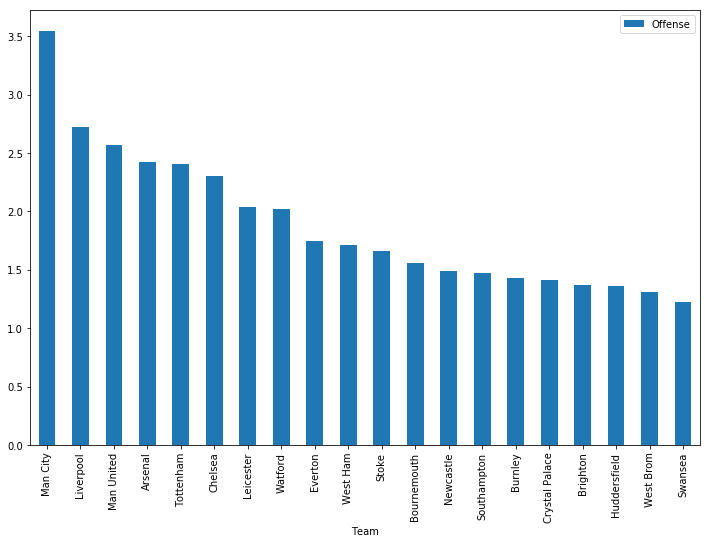

In [14]:
pd.DataFrame(sorted(all_rat["Offense"].items(), reverse=True, key=itemgetter(1)), columns=["Team", "Offense"]).set_index("Team").plot(figsize=(12,8),kind="bar")

#### Defense Ratings (season 17/18):

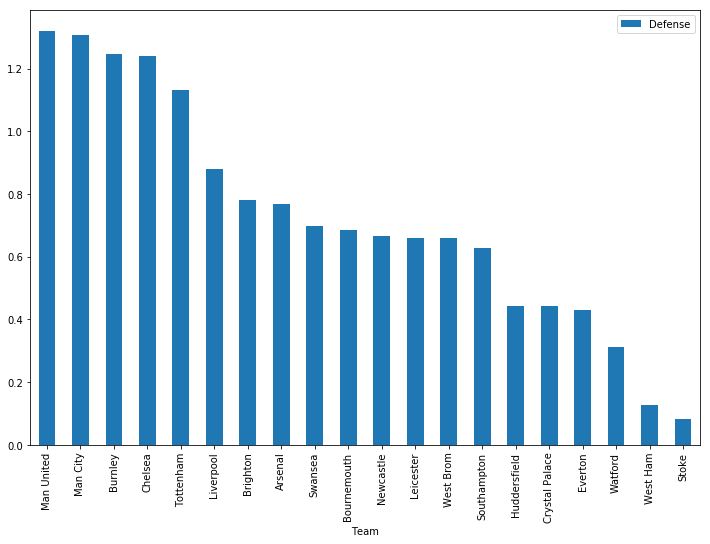

In [15]:
pd.DataFrame(sorted(all_rat["Defense"].items(), reverse=True, key=itemgetter(1)), columns=["Team", "Defense"]).set_index("Team").plot(figsize=(12,8),kind="bar")

### 3.3 Momentum

- Goal difference of the last match (does blowing your opponent away have a positive effect?)
- Momentum over the last 4 matches (ratio of points won in past 4 matches compared to expected points)

In [16]:
df[["HomeTeam", "AwayTeam", "H_Form_Tot4", "A_Form_Tot4", "H_GoalDiff_last", "A_GoalDiff_last"]].tail(10)

,HomeTeam,AwayTeam,H_Form_Tot4,A_Form_Tot4,H_GoalDiff_last,A_GoalDiff_last
370,Burnley,Bournemouth,0.476637,0.799312,-5.0,1.0
371,Crystal Palace,West Brom,1.592183,4.014340,1.0,1.0
372,Huddersfield,Arsenal,1.486229,0.904059,0.0,-2.0
373,Liverpool,Brighton,0.613125,1.691363,-1.0,-2.0
374,Man United,Watford,0.893170,0.908669,0.0,1.0
375,Newcastle,Chelsea,0.000000,1.233296,-1.0,0.0
376,Southampton,Man City,1.315269,0.967432,1.0,2.0
377,Swansea,Stoke,0.000000,0.678686,-1.0,-1.0
378,Tottenham,Leicester,0.741884,0.775903,1.0,2.0
379,West Ham,Everton,1.282501,1.431393,0.0,0.0


## 4. Models

### 4.1 Poisson

- one of the first models for football (80s)
- team specific strengths for attack and defense
- expected goals
- uses the fact that goals roughly follow a poisson distribution

C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
C:\Users\Konny\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


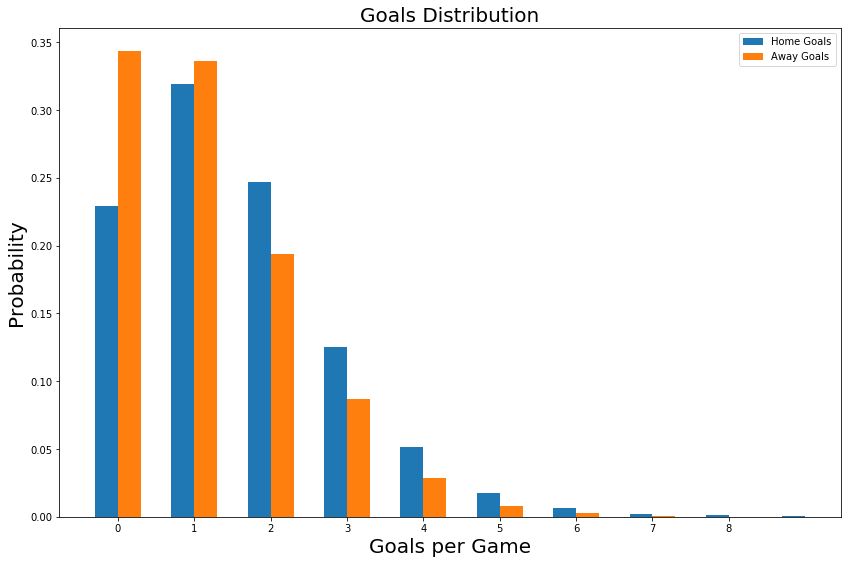

In [17]:
home_goals = df.groupby("FTHG")["FTHG"].count()
away_goals = df.groupby("FTAG")["FTAG"].count()
home_mean = df["FTHG"].mean()
away_mean = df["FTAG"].mean()

home_pois = [poisson.pmf(i, home_mean) * df.shape[0] for i in range(9)]
away_pois = [poisson.pmf(i, away_mean) * df.shape[0] for i in range(9)]

xnew = np.linspace(0, 8, 300)

home_pois_sm = spline(range(9),home_pois,xnew)
away_pois_sm = spline(range(9),away_pois,xnew)

plt.figure(figsize = (14,9))          

plt.title("Goals Distribution", fontsize=20)

plt.bar(home_goals.index-0.15, home_goals.values / df.shape[0], 0.3, label='Home Goals')
plt.bar(away_goals.index+0.15, away_goals.values / df.shape[0], 0.3, label='Away Goals')

plt.ylabel('Probability', fontsize= 20)
plt.xlabel('Goals per Game', fontsize=20)
plt.xticks(np.arange(0, 9, step=1))
plt.legend()

plt.show()

In [18]:
print(f"\nAverage Home Goals per game: {np.round(home_mean, 2)}\n")
print(f"\nAverage Away Goals per game: {np.round(away_mean, 2)}\n")


Average Home Goals per game: 1.55


Average Away Goals per game: 1.16



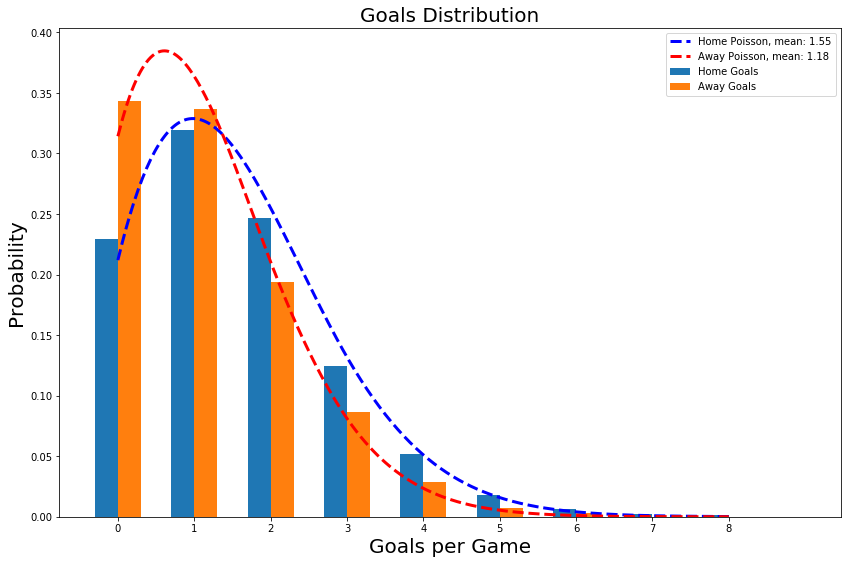

In [19]:
plt.figure(figsize = (14,9))          

plt.title("Goals Distribution", fontsize=20)

plt.bar(home_goals.index-0.15, home_goals.values / df.shape[0], 0.3, label='Home Goals')
plt.bar(away_goals.index+0.15, away_goals.values / df.shape[0], 0.3, label='Away Goals')

plt.plot(xnew, home_pois_sm / df.shape[0], color='blue',lw=3, ls="dashed", label='Home Poisson, mean: 1.55')
plt.plot(xnew, away_pois_sm / df.shape[0], color='red', lw=3, ls="dashed", label='Away Poisson, mean: 1.18')

plt.ylabel('Probability', fontsize= 20)
plt.xlabel('Goals per Game', fontsize=20)
plt.xticks(np.arange(0, 9, step=1))
plt.legend()

plt.show()

In [20]:
print("--------------------------------------------")
print(f"Bookmaker RPS: {np.round(df[(df['round'] > 10) & (df['season'] == 18)]['rps_Book'].mean(), 4)}")
print("--------------------------------------------")
print(f"Poisson Model RPS: {np.round(df[(df['round'] > 10) & (df['season'] == 18)]['rps_Poi_mix'].mean(), 4)}")
print("--------------------------------------------")

--------------------------------------------
Bookmaker RPS: 0.1826
--------------------------------------------
Poisson Model RPS: 0.2006
--------------------------------------------


### 4.2 Random Forest

In [21]:
columns_mit_fe  = ['FTR', 'season', 'H_avgGD', 'A_avgGD', 'H_avgG', 'A_avgG', 'H_avgG_c', 'A_avgG_c', 'H_GoalDiff_last', 'A_GoalDiff_last', 'H_xG_PoiMas', 'A_xG_PoiMas', 'H_Form_Tot4', 'A_Form_Tot4','H_Def_Rat', 'H_Off_Rat', 'A_Def_Rat', 'A_Off_Rat', "H_prob_odds", "D_prob_odds", "A_prob_odds"]

data2 = df[df["round"] > 10].reset_index(drop=True)
data = data2.loc[:,columns_mit_fe]
data.dropna(inplace=True)
X_train = data[data["season"]<18].iloc[:,1:]
X_test = data[data["season"]==18].iloc[:,1:]
y_train = data[data["season"]<18].loc[:,"FTR"]
y_test = data[data["season"]==18].loc[:,"FTR"]

![](pics/Decision_Trees.svg)

![](pics/Random_Forest.svg)

In [22]:
clf = RandomForestClassifier(n_estimators=50,max_depth=4, random_state=28)

- training data: seasons 2008 - 2017
- test data: season 2018

In [23]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=28, verbose=0, warm_start=False)

In [24]:
rdf_preds = clf.predict_proba(X_test)

In [25]:
test_df = data2.iloc[data[data["season"] == 18].index]
test_df.reset_index(drop=True, inplace=True)
test_df.loc[:,columns_mit_fe].dropna(inplace=True)
test_df2 = pd.concat([test_df, pd.DataFrame(rdf_preds, columns = ["Clf_A", "Clf_D", "Clf_H"])], axis=1)
test_df2["rps_Clf"] = rps(test_df2["Clf_H"], test_df2["Clf_D"], test_df2["Clf_A"], test_df2["Home"], test_df2["Draw"], test_df2["Away"])

In [26]:
print("--------------------------------------------")
print(f"Bookmaker RPS: {np.round(test_df2['rps_Book'].mean(), 4)}")
print("--------------------------------------------")
print(f"Random Forest RPS: {np.round(test_df2['rps_Clf'].mean(), 4)}")
print("--------------------------------------------")

--------------------------------------------
Bookmaker RPS: 0.1826
--------------------------------------------
Random Forest RPS: 0.1831
--------------------------------------------


##### Feature Importance (by random forest)

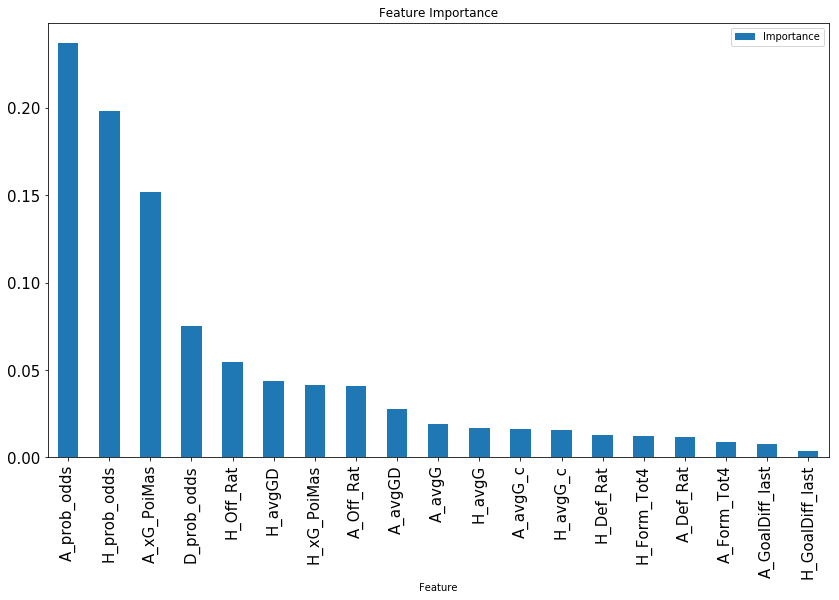

In [27]:
%matplotlib inline
importance = sorted(zip(X_train.columns, clf.feature_importances_), key=itemgetter(1), reverse=True)
fe_imp = pd.DataFrame(importance, columns=["Feature", "Importance"]).set_index("Feature")
fe_imp.drop("season", inplace=True)
fe_imp.plot(figsize=(14, 8),kind='bar', title="Feature Importance", fontsize=15)

- bookie´s odds seem to be a good measure for team strength
- momentum seems unimportant

### 4.3 XGBoost

In [28]:
model = XGBClassifier(n_estimators=50, max_depth=4)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [29]:
xgb_preds = model.predict_proba(X_test)

In [30]:
test_df = data2.iloc[data[data["season"] == 18].index].copy()
test_df.reset_index(drop=True, inplace=True)
test_df.loc[:,columns_mit_fe].dropna(inplace=True)
test_df2 = pd.concat([test_df, pd.DataFrame(xgb_preds, columns = ["Clf_A", "Clf_D", "Clf_H"])], axis=1)
test_df2["rps_Clf"] = rps(test_df2["Clf_H"], test_df2["Clf_D"], test_df2["Clf_A"], test_df2["Home"], test_df2["Draw"], test_df2["Away"])

In [31]:
print("--------------------------------------------")
print(f"Bookmaker RPS: {np.round(test_df2['rps_Book'].mean(), 4)}")
print("--------------------------------------------")
print(f"XGBoost RPS: {np.round(test_df2['rps_Clf'].mean(), 4)}")
print("--------------------------------------------")

--------------------------------------------
Bookmaker RPS: 0.1826
--------------------------------------------
XGBoost RPS: 0.1807
--------------------------------------------


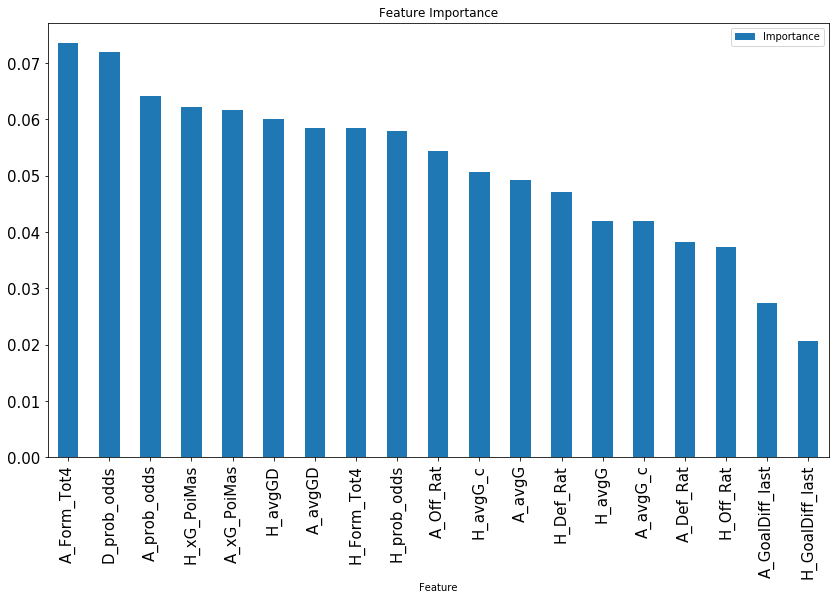

In [32]:
importance = sorted(zip(X_train.columns, model.feature_importances_), key=itemgetter(1), reverse=True)
fe_imp = pd.DataFrame(importance, columns=["Feature", "Importance"]).set_index("Feature")
fe_imp.drop("season", inplace=True)
fe_imp.plot(figsize=(14, 8),kind='bar', title="Feature Importance", fontsize=15)

- goal difference of the last match is again the most unimportant feature
- the more sophisticated momentum measure (Form_Tot4) is now one of the most important features!

### 4.4 Artificial Neural Network

In [33]:
columns_mit_fe  = ['Home', 'Draw', 'Away', 'season', 'H_avgGD', 'A_avgGD', 'H_avgG', 'A_avgG', 'H_avgG_c', 'A_avgG_c', 'H_avgST', 'A_avgST', 'H_avgST_c', 'A_avgST_c', 'H_GoalDiff_last', 'A_GoalDiff_last', 'H_xG_PoiMas', 'A_xG_PoiMas', 'H_Form_Tot4', 'A_Form_Tot4','H_Def_Rat', 'H_Off_Rat', 'A_Def_Rat', 'A_Off_Rat', "H_prob_odds", "D_prob_odds", "A_prob_odds"]

def get_season(df, season):
    X_train = df[df["season"] < season].iloc[:,4:]
    X_test = df[df["season"] == season].iloc[:,4:]
    y_train = df[df["season"] < season].iloc[:,:3]
    y_test = df[df["season"] == season].iloc[:,:3]
    return X_train, X_test, y_train, y_test

data2 = df[df["round"] > 10].reset_index(drop=True)
data = data2.loc[:,columns_mit_fe]
data.dropna(inplace=True)

X_train, X_test, y_train, y_test = get_season(data, 18)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
def loss_rps(y_true, y_pred):
    prob_h = y_pred[:, 0]
    prob_d = y_pred[:, 1]
    home = y_true[:, 0]
    draw = y_true[:, 1]

    step1 = prob_h - home
    step2 = prob_d - draw
    summe = step1 + step2
    return (step1 ** 2 + summe ** 2) / 2

In [35]:
K.clear_session()

model = Sequential()
model.add(Dense(128, kernel_initializer="he_normal", input_shape=(23,)))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(3, kernel_initializer="he_normal"))
model.add(Activation('softmax'))

model.compile(loss=loss_rps, optimizer='adam', metrics=['accuracy'])

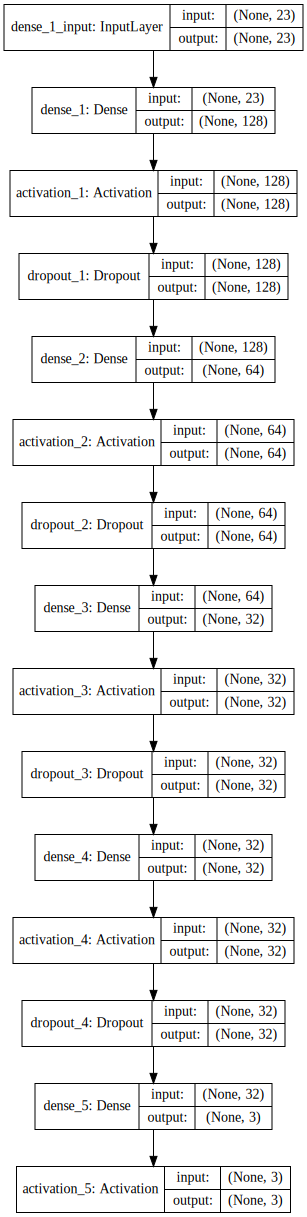

In [36]:
SVG(model_to_dot(model,  show_shapes=True,
    show_layer_names=True, rankdir='HB').create(
       prog='dot', format='svg'))

In [37]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Train on 2798 samples, validate on 280 samples
Epoch 1/100
2798/2798 [==============================] - 2s 606us/step - loss: 0.3061 - acc: 0.3967 - val_loss: 0.2225 - val_acc: 0.4750
Epoch 2/100
2798/2798 [==============================] - 0s 68us/step - loss: 0.2725 - acc: 0.4328 - val_loss: 0.2267 - val_acc: 0.5179
Epoch 3/100
2798/2798 [==============================] - 0s 91us/step - loss: 0.2629 - acc: 0.4635 - val_loss: 0.2238 - val_acc: 0.5393
Epoch 4/100
2798/2798 [==============================] - 0s 98us/step - loss: 0.2547 - acc: 0.4539 - val_loss: 0.2155 - val_acc: 0.5357
Epoch 5/100
2798/2798 [==============================] - 0s 93us/step - loss: 0.2437 - acc: 0.4478 - val_loss: 0.2091 - val_acc: 0.5393
Epoch 6/100
2798/2798 [==============================] - 0s 87us/step - loss: 0.2384 - acc: 0.4535 - val_loss: 0.2053 - val_acc: 0.5214
Epoch 7/100
2798/2798 [==============================] - 0s 90us/step - loss: 0.2205 - acc: 0.4732 - val_loss: 0.1987 - val_acc: 0.5286


2798/2798 [==============================] - 0s 68us/step - loss: 0.1919 - acc: 0.5454 - val_loss: 0.1836 - val_acc: 0.5393
Epoch 61/100
2798/2798 [==============================] - 0s 69us/step - loss: 0.1927 - acc: 0.5533 - val_loss: 0.1846 - val_acc: 0.5429
Epoch 62/100
2798/2798 [==============================] - 0s 67us/step - loss: 0.1924 - acc: 0.5422 - val_loss: 0.1835 - val_acc: 0.5500
Epoch 63/100
2798/2798 [==============================] - 0s 69us/step - loss: 0.1917 - acc: 0.5490 - val_loss: 0.1843 - val_acc: 0.5464
Epoch 64/100
2798/2798 [==============================] - 0s 68us/step - loss: 0.1918 - acc: 0.5533 - val_loss: 0.1836 - val_acc: 0.5536
Epoch 65/100
2798/2798 [==============================] - 0s 68us/step - loss: 0.1924 - acc: 0.5497 - val_loss: 0.1840 - val_acc: 0.5500
Epoch 66/100
2798/2798 [==============================] - 0s 69us/step - loss: 0.1916 - acc: 0.5522 - val_loss: 0.1848 - val_acc: 0.5464
Epoch 67/100
2798/2798 [==============================

In [38]:
print("--------------------------------------------")
print(f"Train Dataset:\n RPS: {np.round(model.evaluate(X_train, y_train, verbose=0)[0],4)}, Accuracy: {np.round(model.evaluate(X_train, y_train, verbose=0)[1],4)}")
print("--------------------------------------------")
print(f"Test Dataset:\n RPS: {np.round(model.evaluate(X_test, y_test, verbose=0)[0],4)}, Accuracy: {np.round(model.evaluate(X_test, y_test, verbose=0)[1],4)}")
print("--------------------------------------------")

--------------------------------------------
Train Dataset:
 RPS: 0.179, Accuracy: 0.5718
--------------------------------------------
Test Dataset:
 RPS: 0.1847, Accuracy: 0.5464
--------------------------------------------


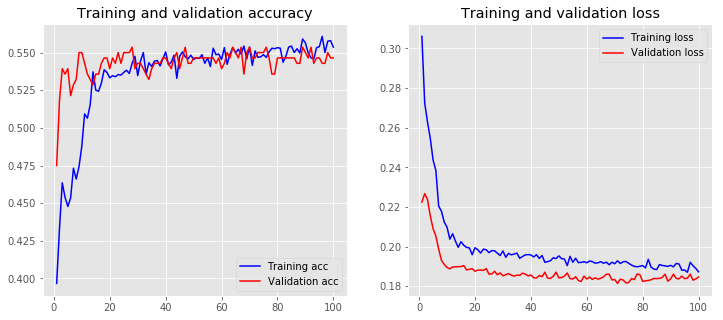

In [39]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


plot_history(history)

In [40]:
ann_preds = model.predict(X_test)

In [41]:
test_df = data2.iloc[data[data["season"] == 18].index]
test_df.reset_index(drop=True, inplace=True)
rdf_pred = pd.DataFrame(rdf_preds, columns = ["A_pred_Rdf", "D_pred_Rdf", "H_pred_Rdf"])
xgb_pred = pd.DataFrame(xgb_preds, columns = ["A_pred_Xgb", "D_pred_Xgb", "H_pred_Xgb"])
ann_pred = pd.DataFrame(ann_preds, columns = ["H_pred_Ann", "D_pred_Ann", "A_pred_Ann"])
test_df2 = pd.concat([test_df, rdf_pred, xgb_pred, ann_pred], axis=1)
test_df2["rps_Rdf"] = rps(test_df2["H_pred_Rdf"], test_df2["D_pred_Rdf"], test_df2["A_pred_Rdf"], test_df2["Home"], test_df2["Draw"], test_df2["Away"])
test_df2["rps_Xgb"] = rps(test_df2["H_pred_Xgb"], test_df2["D_pred_Xgb"], test_df2["A_pred_Xgb"], test_df2["Home"], test_df2["Draw"], test_df2["Away"])
test_df2["rps_ANN"] = rps(test_df2["H_pred_Ann"], test_df2["D_pred_Ann"], test_df2["A_pred_Ann"], test_df2["Home"], test_df2["Draw"], test_df2["Away"])

In [42]:
print("--------------------------------------------")
print("METHOD:             RPS:")
print("--------------------------------------------")
print(f"Bookmaker:          {np.round(test_df2['rps_Book'].mean(), 4)}")
print("--------------------------------------------")
print(f"Poisson:            {np.round(test_df2['rps_Poi_mix'].mean(), 4)}")
print("--------------------------------------------")
print(f"Random Forest:      {np.round(test_df2['rps_Rdf'].mean(), 4)}")
print("--------------------------------------------")
print(f"XGBoost:            {np.round(test_df2['rps_Xgb'].mean(), 4)}")
print("--------------------------------------------")
print(f"Neural Network:     {np.round(test_df2['rps_ANN'].mean(), 4)}")
print("--------------------------------------------")

--------------------------------------------
METHOD:             RPS:
--------------------------------------------
Bookmaker:          0.1826
--------------------------------------------
Poisson:            0.2006
--------------------------------------------
Random Forest:      0.1831
--------------------------------------------
XGBoost:            0.1807
--------------------------------------------
Neural Network:     0.1847
--------------------------------------------


## 5. Betting Strategy

place bet, if the average of the predictions suggests a higher winning probability than the odds by a certain margin

In [43]:
test_df2["H_pred_avg"] = (test_df2["H_pred_Rdf"] + test_df2["H_pred_Xgb"] + test_df2["H_pred_Ann"]) / 3
test_df2["D_pred_avg"] = (test_df2["D_pred_Rdf"] + test_df2["D_pred_Xgb"] + test_df2["D_pred_Ann"]) / 3
test_df2["A_pred_avg"] = (test_df2["A_pred_Rdf"] + test_df2["A_pred_Xgb"] + test_df2["A_pred_Ann"]) / 3

test_df2[["HomeTeam", "AwayTeam", "H_prob_odds", "H_pred_Rdf", "H_pred_Xgb", "H_pred_Ann", "H_pred_avg"]].tail()

,HomeTeam,AwayTeam,H_prob_odds,H_pred_Rdf,H_pred_Xgb,H_pred_Ann,H_pred_avg
275,Newcastle,Chelsea,0.200072,0.257097,0.195454,0.104711,0.185754
276,Southampton,Man City,0.153666,0.153056,0.120598,0.136419,0.136691
277,Swansea,Stoke,0.469754,0.504860,0.534276,0.458678,0.499271
278,Tottenham,Leicester,0.704109,0.774319,0.660950,0.775119,0.736796
279,West Ham,Everton,0.415345,0.422441,0.420291,0.446687,0.429806


In [44]:
test_df2["rps_avg"] = rps(test_df2["H_pred_avg"], test_df2["D_pred_avg"], test_df2["A_pred_avg"], test_df2["Home"], test_df2["Draw"], test_df2["Away"])

print("--------------------------------------------")
print(f"Average prediction RPS: {np.round(test_df2['rps_avg'].mean(), 4)}")
print("--------------------------------------------")

--------------------------------------------
Average prediction RPS: 0.1808
--------------------------------------------


##### Profit/Loss on Home Bets:

In [45]:
value = 0.1

a = test_df2[test_df2["H_pred_avg"] / test_df2["H_prob_odds"] -1 > value]["H_PL"].describe()
print(f"\nBets on Home Teams in 1X2 market:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(a['count'])}\nAvg. Yield: {np.round(a['mean'] * 100, 2)}%\nMax winning odds: {np.round(a['max'] + 1, 2)}")
print("======================================================================")
b = test_df2[test_df2["H_pred_avg"] / test_df2["H_prob_odds"] -1 > value]["H_Ahc_PL"].describe()
print(f"\nBets on Home Teams in asian handicap market:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(b['count'])}\nAvg. Yield: {np.round(b['mean'] * 100, 2)}%\nMax winning odds: {np.round(b['max'] + 1, 2)}")


Bets on Home Teams in 1X2 market:

Nr of Matches: 280
Nr of Bets: 76
Avg. Yield: 10.38%
Max winning odds: 11.68

Bets on Home Teams in asian handicap market:

Nr of Matches: 280
Nr of Bets: 76
Avg. Yield: 6.59%
Max winning odds: 2.29


##### Profit/Loss on Away Bets:

In [46]:
c = test_df2[test_df2["A_pred_avg"] / test_df2["A_prob_odds"] -1 > value]["A_PL"].describe()
print(f"\nBets on Away Teams in 1X2 market:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(c['count'])}\nAvg. Yield: {np.round(c['mean'] * 100, 2)}%\nMax winning odds: {np.round(c['max'] + 1, 2)}")
print("======================================================================")
d = test_df2[test_df2["A_pred_avg"] / test_df2["A_prob_odds"] -1 > value]["A_Ahc_PL"].describe()
print(f"\nBets on Away Teams in asian handicap market:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(d['count'])}\nAvg. Yield: {np.round(d['mean'] * 100, 2)}%\nMax winning odds: {np.round(d['max'] + 1, 2)}")


Bets on Away Teams in 1X2 market:

Nr of Matches: 280
Nr of Bets: 26
Avg. Yield: 24.04%
Max winning odds: 6.58

Bets on Away Teams in asian handicap market:

Nr of Matches: 280
Nr of Bets: 26
Avg. Yield: 16.52%
Max winning odds: 2.08


## 6. Predicting Goals

#### XGB Regressor

In [47]:
columns_mit_fe  = ['FTHG', 'FTAG', 'season', 'H_avgGD', 'A_avgGD', 'H_avgG', 'A_avgG', 'H_avgG_c', 'A_avgG_c', 'H_avgST', 'A_avgST', 'H_avgST_c', 'A_avgST_c', 'H_GoalDiff_last', 'A_GoalDiff_last', 'H_xG_PoiMas', 'A_xG_PoiMas', 'H_Form_Tot4', 'A_Form_Tot4','H_Def_Rat', 'H_Off_Rat', 'A_Def_Rat', 'A_Off_Rat', "H_prob_odds", "D_prob_odds", "A_prob_odds"]
def get_season(df, season):
    X_train = df[df["season"] < season].iloc[:,2:]
    X_test = df[df["season"] == season].iloc[:,2:]
    y_train_hg = df[df["season"] < season].iloc[:,0]
    y_test_hg = df[df["season"] == season].iloc[:,0]
    y_train_ag = df[df["season"] < season].iloc[:,1]
    y_test_ag = df[df["season"] == season].iloc[:,1]
    return X_train, X_test, y_train_hg, y_test_hg, y_train_ag, y_test_ag

data2 = df[df["round"] > 10].reset_index(drop=True)
data = data2.loc[:,columns_mit_fe]
data.dropna(inplace=True)

X_train, X_test, y_train_hg, y_test_hg, y_train_ag, y_test_ag = get_season(data, 18)

del X_train["season"]
del X_test["season"]

In [48]:
#home
model_h = XGBRegressor(n_estimators=50, max_depth=4)
model_h.fit(X_train, y_train_hg)
xgb_home = model_h.predict(X_test)

#away
model_a = XGBRegressor(n_estimators=50, max_depth=4)
model_a.fit(X_train, y_train_ag)
xgb_away = model_a.predict(X_test)

### SVR

In [49]:
columns_mit_fe  = ['FTHG', 'FTAG', 'season', 'H_avgGD', 'A_avgGD', 'H_avgG', 'A_avgG', 'H_avgG_c', 'A_avgG_c', 'H_avgST', 'A_avgST', 'H_avgST_c', 'A_avgST_c', 'H_GoalDiff_last', 'A_GoalDiff_last', 'H_xG_PoiMas', 'A_xG_PoiMas', 'H_Form_Tot4', 'A_Form_Tot4','H_Def_Rat', 'H_Off_Rat', 'A_Def_Rat', 'A_Off_Rat', "H_prob_odds", "D_prob_odds", "A_prob_odds"]

def get_season(df, season):
    X_train = df[df["season"] < season].iloc[:,2:]
    X_test = df[df["season"] == season].iloc[:,2:]
    y_train_hg = df[df["season"] < season].iloc[:,0]
    y_test_hg = df[df["season"] == season].iloc[:,0]
    y_train_ag = df[df["season"] < season].iloc[:,1]
    y_test_ag = df[df["season"] == season].iloc[:,1]
    return X_train, X_test, y_train_hg, y_test_hg, y_train_ag, y_test_ag

data2 = df[df["round"] > 10].reset_index(drop=True)
data = data2.loc[:,columns_mit_fe]
data.dropna(inplace=True)

X_train, X_test, y_train_hg, y_test_hg, y_train_ag, y_test_ag = get_season(data, 18)

del X_train["season"]
del X_test["season"]

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [50]:
#home
model_h = SVR(C=0.01)
model_h.fit(X_train, y_train_hg)
svr_home = model_h.predict(X_test)

#away
model_a = SVR(C=0.01)
model_a.fit(X_train, y_train_ag)
svr_away = model_a.predict(X_test)

### Artificial Neural Network

In [51]:
columns_mit_fe  = ['FTHG', 'FTAG', 'season', 'H_avgGD', 'A_avgGD', 'H_avgG', 'A_avgG', 'H_avgG_c', 'A_avgG_c', 'H_avgST', 'A_avgST', 'H_avgST_c', 'A_avgST_c', 'H_GoalDiff_last', 'A_GoalDiff_last', 'H_xG_PoiMas', 'A_xG_PoiMas', 'H_Form_Tot4', 'A_Form_Tot4','H_Def_Rat', 'H_Off_Rat', 'A_Def_Rat', 'A_Off_Rat', "H_prob_odds", "D_prob_odds", "A_prob_odds"]

def get_season(df, season):
    X_train = df[df["season"] < season].iloc[:,2:]
    X_test = df[df["season"] == season].iloc[:,2:]
    y_train = df[df["season"] < season].iloc[:,:2]
    y_test = df[df["season"] == season].iloc[:,:2]
    return X_train, X_test, y_train, y_test


data2 = df[df["round"] > 10].reset_index(drop=True)
data = data2.loc[:,columns_mit_fe]
data.dropna(inplace=True)

X_train, X_test, y_train, y_test = get_season(data, 18)

del X_train["season"]
del X_test["season"]

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [52]:
K.clear_session()

model = Sequential()
model.add(Dense(128, kernel_initializer="he_normal", input_shape=(23,)))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(2, kernel_initializer="he_normal"))
model.add(Activation('linear'))

model.compile(loss="logcosh", optimizer='adam', metrics=['accuracy'])

In [53]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Train on 2798 samples, validate on 280 samples
Epoch 1/100
2798/2798 [==============================] - 0s 163us/step - loss: 1.0180 - acc: 0.5508 - val_loss: 0.5949 - val_acc: 0.7250
Epoch 2/100
2798/2798 [==============================] - 0s 75us/step - loss: 0.7539 - acc: 0.5969 - val_loss: 0.5414 - val_acc: 0.7321
Epoch 3/100
2798/2798 [==============================] - 0s 62us/step - loss: 0.6554 - acc: 0.6169 - val_loss: 0.5208 - val_acc: 0.7750
Epoch 4/100
2798/2798 [==============================] - 0s 58us/step - loss: 0.6017 - acc: 0.6401 - val_loss: 0.4976 - val_acc: 0.7571
Epoch 5/100
2798/2798 [==============================] - 0s 66us/step - loss: 0.5675 - acc: 0.6497 - val_loss: 0.4854 - val_acc: 0.7429
Epoch 6/100
2798/2798 [==============================] - 0s 69us/step - loss: 0.5436 - acc: 0.6841 - val_loss: 0.4812 - val_acc: 0.7536
Epoch 7/100
2798/2798 [==============================] - 0s 62us/step - loss: 0.5370 - acc: 0.6758 - val_loss: 0.4728 - val_acc: 0.7143


2798/2798 [==============================] - 0s 63us/step - loss: 0.4608 - acc: 0.7187 - val_loss: 0.4448 - val_acc: 0.7357
Epoch 61/100
2798/2798 [==============================] - 0s 103us/step - loss: 0.4604 - acc: 0.7219 - val_loss: 0.4448 - val_acc: 0.7500
Epoch 62/100
2798/2798 [==============================] - 0s 71us/step - loss: 0.4557 - acc: 0.7219 - val_loss: 0.4453 - val_acc: 0.7393
Epoch 63/100
2798/2798 [==============================] - 0s 93us/step - loss: 0.4592 - acc: 0.7173 - val_loss: 0.4446 - val_acc: 0.7321
Epoch 64/100
2798/2798 [==============================] - 0s 69us/step - loss: 0.4564 - acc: 0.7198 - val_loss: 0.4444 - val_acc: 0.7250
Epoch 65/100
2798/2798 [==============================] - 0s 64us/step - loss: 0.4568 - acc: 0.7198 - val_loss: 0.4444 - val_acc: 0.7429
Epoch 66/100
2798/2798 [==============================] - 0s 64us/step - loss: 0.4562 - acc: 0.7284 - val_loss: 0.4453 - val_acc: 0.7500
Epoch 67/100
2798/2798 [=============================

In [54]:
print(f"Train Dataset:\n Loss: {np.round(model.evaluate(X_train, y_train, verbose=0)[0],4)}, Accuracy: {np.round(model.evaluate(X_train, y_train, verbose=0)[1],4)}")
print("--------------------------------------------")
print(f"Test Dataset:\n Loss: {np.round(model.evaluate(X_test, y_test, verbose=0)[0],4)}, Accuracy: {np.round(model.evaluate(X_test, y_test, verbose=0)[1],4)}")
print("--------------------------------------------")

Train Dataset:
 Loss: 0.4379, Accuracy: 0.7252
--------------------------------------------
Test Dataset:
 Loss: 0.4457, Accuracy: 0.7179
--------------------------------------------


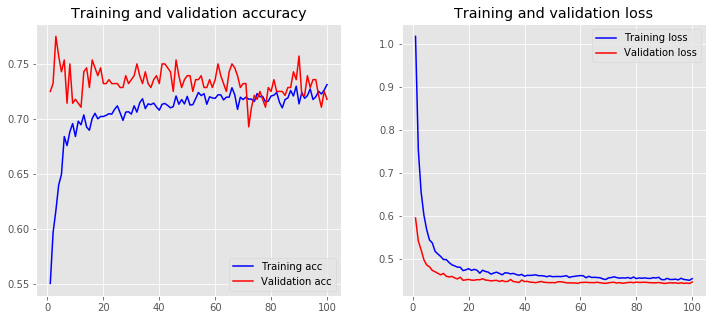

In [55]:
plot_history(history)

In [56]:
y_pred = model.predict(X_test)

test_df = data2.iloc[data[data["season"] == 18].index].copy()
test_df.reset_index(drop=True, inplace=True)

test_df["H_xgb_xG"] = xgb_home
test_df["A_xgb_xG"] = xgb_away
test_df["XGB_hc"] = test_df["A_xgb_xG"] - test_df["H_xgb_xG"]
test_df["Hc_Diff_xgb"] = test_df["BbAHh"] - test_df["XGB_hc"]

test_df["H_svr_xG"] = svr_home
test_df["A_svr_xG"] = svr_away
test_df["SVR_hc"] = test_df["A_svr_xG"] - test_df["H_svr_xG"]
test_df["Hc_Diff_svr"] = test_df["BbAHh"] - test_df["SVR_hc"]

ann_pred2 = pd.DataFrame(y_pred, columns = ["H_ann_xG", "A_ann_xG"])
test_df2 = pd.concat([test_df, ann_pred2], axis=1)
test_df2["ANN_hc"] = test_df2["A_ann_xG"] - test_df2["H_ann_xG"]
test_df2["Hc_Diff_ann"] = test_df2["BbAHh"] - test_df2["ANN_hc"]

## 7. Betting Strategy

place bet, if the average predicted goal difference is different than the handicap of the bookies by a certain margin

In [57]:
test_df2["Hc_Diff_avg"] = (test_df2["Hc_Diff_ann"] + test_df2["Hc_Diff_xgb"] + test_df2["Hc_Diff_svr"]) / 3
test_df2[["HomeTeam", "AwayTeam", "Hc_Diff_ann", "Hc_Diff_xgb", "Hc_Diff_svr", "Hc_Diff_avg"]].tail()

,HomeTeam,AwayTeam,Hc_Diff_ann,Hc_Diff_xgb,Hc_Diff_svr,Hc_Diff_avg
275,Newcastle,Chelsea,0.141015,0.317236,0.863920,0.440724
276,Southampton,Man City,-0.051284,0.526193,1.203707,0.559539
277,Swansea,Stoke,0.029459,-0.322093,-0.202333,-0.164989
278,Tottenham,Leicester,0.118904,0.036528,-0.453609,-0.099392
279,West Ham,Everton,0.093770,0.066952,-0.084995,0.025243


##### Profit/Loss on Home Bets:

In [58]:
difference = 0.25

a = test_df2[test_df2["Hc_Diff_avg"] > difference].H_PL.describe()
print(f"\nBets on Home Teams in 1X2 market:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(a['count'])}\nAvg. Yield: {np.round(a['mean'] * 100, 2)}%\nMax winning odds: {np.round(a['max'] + 1, 2)}")
print("======================================================================")
b = test_df2[test_df2["Hc_Diff_avg"] > difference].H_Ahc_PL.describe()
print(f"\nBets on Home Teams in asian handicap market:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(b['count'])}\nAvg. Yield: {np.round(b['mean'] * 100, 2)}%\nMax winning odds: {np.round(b['max'] + 1, 2)}")


Bets on Home Teams in 1X2 market:

Nr of Matches: 280
Nr of Bets: 43
Avg. Yield: 43.7%
Max winning odds: 11.68

Bets on Home Teams in asian handicap market:

Nr of Matches: 280
Nr of Bets: 43
Avg. Yield: 15.3%
Max winning odds: 2.11


##### Profit/Loss on Away Bets:

In [59]:
c = test_df2[test_df2["Hc_Diff_avg"] < -difference].A_PL.describe()
print(f"\nBets on Away Teams in 1X2 market:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(c['count'])}\nAvg. Yield: {np.round(c['mean'] * 100, 2)}%\nMax winning odds: {np.round(c['max'] + 1, 2)}")
print("======================================================================")
d = test_df2[test_df2["Hc_Diff_avg"] < -difference].A_Ahc_PL.describe()
print(f"\nBets on Away Teams in asian handicap market:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(d['count'])}\nAvg. Yield: {np.round(d['mean'] * 100, 2)}%\nMax winning odds: {np.round(d['max'] + 1, 2)}")


Bets on Away Teams in 1X2 market:

Nr of Matches: 280
Nr of Bets: 56
Avg. Yield: -9.18%
Max winning odds: 18.0

Bets on Away Teams in asian handicap market:

Nr of Matches: 280
Nr of Bets: 56
Avg. Yield: -0.06%
Max winning odds: 2.01


### Combination between Classification and Regression

In [60]:
test_df3 = pd.concat([test_df2, rdf_pred, xgb_pred, ann_pred], axis=1)
test_df3["rps_Rdf"] = rps(test_df3["H_pred_Rdf"], test_df3["D_pred_Rdf"], test_df3["A_pred_Rdf"], test_df3["Home"], test_df3["Draw"], test_df3["Away"])
test_df3["rps_Xgb"] = rps(test_df3["H_pred_Xgb"], test_df3["D_pred_Xgb"], test_df3["A_pred_Xgb"], test_df3["Home"], test_df3["Draw"], test_df3["Away"])
test_df3["rps_ANN"] = rps(test_df3["H_pred_Ann"], test_df3["D_pred_Ann"], test_df3["A_pred_Ann"], test_df3["Home"], test_df3["Draw"], test_df3["Away"])

test_df3["H_pred_avg"] = (test_df3["H_pred_Rdf"] + test_df3["H_pred_Xgb"] + test_df3["H_pred_Ann"]) / 3
test_df3["D_pred_avg"] = (test_df3["D_pred_Rdf"] + test_df3["D_pred_Xgb"] + test_df3["D_pred_Ann"]) / 3
test_df3["A_pred_avg"] = (test_df3["A_pred_Rdf"] + test_df3["A_pred_Xgb"] + test_df3["A_pred_Ann"]) / 3
test_df3["rps_avg"] = rps(test_df3["H_pred_avg"], test_df3["D_pred_avg"], test_df3["A_pred_avg"], test_df3["Home"], test_df3["Draw"], test_df3["Away"])

In [61]:
difference = 0.1
value = 0.1

In [62]:
a = test_df3[(test_df3["Hc_Diff_avg"] > difference) & (test_df3["H_pred_avg"] / test_df3["H_prob_odds"] - 1 > value)].H_PL.describe()
print(f"\nBets on Home Teams in 1X2 market:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(a['count'])}\nAvg. Yield: {np.round(a['mean'] * 100, 2)}%\nMax winning odds: {np.round(a['max'] + 1, 2)}")
print("======================================================================")
b = test_df3[(test_df3["Hc_Diff_avg"] > difference) & (test_df3["H_pred_avg"] / test_df3["H_prob_odds"] - 1 > value)].H_Ahc_PL.describe()
print(f"\nBets on Home Teams in asian handicap market:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(b['count'])}\nAvg. Yield: {np.round(b['mean'] * 100, 2)}%\nMax winning odds: {np.round(b['max'] + 1, 2)}")


Bets on Home Teams in 1X2 market:

Nr of Matches: 280
Nr of Bets: 50
Avg. Yield: 30.8%
Max winning odds: 11.68

Bets on Home Teams in asian handicap market:

Nr of Matches: 280
Nr of Bets: 50
Avg. Yield: 20.16%
Max winning odds: 2.11


In [63]:

c = test_df3[(test_df3["Hc_Diff_avg"] < -difference) & (test_df3["A_pred_avg"] / test_df3["A_prob_odds"] - 1 > value)].A_PL.describe()
print(f"\nBets on Away Teams in 1X2 market:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(c['count'])}\nAvg. Yield: {np.round(c['mean'] * 100, 2)}%\nMax winning odds: {np.round(c['max'] + 1, 2)}")
print("======================================================================")
d = test_df3[(test_df3["Hc_Diff_avg"] < -difference) & (test_df3["A_pred_avg"] / test_df3["A_prob_odds"] - 1 > value)].A_Ahc_PL.describe()
print(f"\nBets on Away Teams in asian handicap market:\n\nNr of Matches: {test_df2.shape[0]}\nNr of Bets: {int(d['count'])}\nAvg. Yield: {np.round(d['mean'] * 100, 2)}%\nMax winning odds: {np.round(d['max'] + 1, 2)}")


Bets on Away Teams in 1X2 market:

Nr of Matches: 280
Nr of Bets: 16
Avg. Yield: -28.81%
Max winning odds: 5.01

Bets on Away Teams in asian handicap market:

Nr of Matches: 280
Nr of Bets: 16
Avg. Yield: 15.66%
Max winning odds: 1.96


## 7. Still To Do:
- Get hands on more detailed data
- LineUps
- Market Value
- Twitter Sentiment Analysis of the matches
- GUI